In [1]:
import pandas as pd
from pathlib import Path
import yaml
import numpy as np
import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed

## Split benchmarks into batches for GCP run

In [2]:
meta = yaml.safe_load(open('results/metadata.yaml'))
benchs_by_size = {'S': [], 'M': [], 'L': []}
for n, b in meta['benchmarks'].items():
    for s in b['Sizes']:
        instance = {'Name': s['Name'], 'Size': s['Size'], 'URL': s['URL']}
        benchs_by_size[s['Size']].append((s['Num. variables'] + s['Num. constraints'], n, instance))
', '.join([f'{s}: {len(bs)}' for s, bs in benchs_by_size.items()])

'S: 18, M: 87, L: 15'

### Run 20250426_1318*: all S benchmarks

In [3]:
# Use longest-processing-time-first greedy algorithm to split benchs into VMs
num_vms = 9
allocation = [[] for _ in range(num_vms)]
weights = [0 for _ in range(num_vms)]

small_benchs = []
for n, b in meta['benchmarks'].items():
    for s in b['Sizes']:
        if s['Size'] == 'S':
            instance = {'Name': s['Name'], 'Size': s['Size'], 'URL': s['URL']}
            small_benchs.append((s['Num. variables'], n, instance))
small_benchs = sorted(small_benchs, reverse=True)
num_benchs = len(small_benchs)

for w, n, b in small_benchs:
    lightest_vm = min(enumerate(weights), key=lambda x: x[1])[0]
    allocation[lightest_vm].append((n, b))
    weights[lightest_vm] += w

[len(vm) for vm in allocation], weights


([2, 2, 2, 2, 2, 2, 2, 2, 2],
 [13956, 10686, 10438, 16443, 16329, 16200, 16200, 16200, 13567])

In [4]:
# Write allocation to infrastructure/benchmarks/ for Open Tofu:
for i, benchs in enumerate(allocation):
    y = {
        'machine-type': 'c4-standard-2', # TODO modify based on size!
        'years': [2020, 2022, 2023, 2024, 2025],
        'benchmarks': {n: {'Sizes': [b]} for n, b in benchs},
    }
    with open(f'infrastructure/benchmarks/{i:02d}.yaml', 'w') as f:
        yaml.safe_dump(y, f)

### Run 20250428*: all M & L benchmarks

In [5]:
# Estimate max runtime of running each L separately, and M among remaining VMs, 40 total
from math import ceil
max(4*10, ceil(81/(40-15))*13*1)

52

In [6]:
num_vms = 40
allocation = [[] for _ in range(num_vms)]
weights = [0 for _ in range(num_vms)]

In [7]:
# Put each L benchmark in its own VM
for i, (_, n, b) in enumerate(benchs_by_size['L']):
    allocation[i].append((n, b))
    weights[i] = np.inf  # To avoid the greedy algo below putting M benchs into these VMs

In [8]:
# Use longest-processing-time-first greedy algorithm to split M benchs into VMs

med_benchs = sorted(benchs_by_size['M'], reverse=True)
num_benchs = len(med_benchs)

for w, n, b in med_benchs:
    lightest_vm = min(enumerate(weights), key=lambda x: x[1])[0]
    allocation[lightest_vm].append((n, b))
    weights[lightest_vm] += w

print('\n'.join((f'{i}: {len(allocation[i])} benchs, weight {weights[i]}' for i in range(len(weights)))))

0: 1 benchs, weight inf
1: 1 benchs, weight inf
2: 1 benchs, weight inf
3: 1 benchs, weight inf
4: 1 benchs, weight inf
5: 1 benchs, weight inf
6: 1 benchs, weight inf
7: 1 benchs, weight inf
8: 1 benchs, weight inf
9: 1 benchs, weight inf
10: 1 benchs, weight inf
11: 1 benchs, weight inf
12: 1 benchs, weight inf
13: 1 benchs, weight inf
14: 1 benchs, weight inf
15: 1 benchs, weight 2371231
16: 1 benchs, weight 1874649
17: 1 benchs, weight 1863767
18: 1 benchs, weight 1562435
19: 1 benchs, weight 1384058
20: 1 benchs, weight 1374373
21: 3 benchs, weight 1212634
22: 2 benchs, weight 1191333
23: 3 benchs, weight 1199821
24: 4 benchs, weight 1220324
25: 3 benchs, weight 1187250
26: 4 benchs, weight 1216372
27: 4 benchs, weight 1218027
28: 3 benchs, weight 1186527
29: 5 benchs, weight 1212419
30: 5 benchs, weight 1213030
31: 5 benchs, weight 1210842
32: 5 benchs, weight 1211014
33: 5 benchs, weight 1198379
34: 5 benchs, weight 1192631
35: 5 benchs, weight 1194956
36: 6 benchs, weight 12121

In [9]:
# Write allocation to infrastructure/benchmarks/ for Open Tofu:
for i, benchs in enumerate(allocation):
    if weights[i] == np.inf:
        size = 'L'
        years = [2024, 2025]
    else:
        size ='M'
        years = [2020, 2022, 2023, 2024, 2025]
    y = {
        'machine-type': 'c4-standard-2' if size == 'M' else 'c4-highmem-8',
        'years': years,
        'benchmarks': {n: {'Sizes': [b]} for n, b in benchs},
    }
    with open(f'infrastructure/benchmarks/{size.lower()}{i:02d}.yaml', 'w') as f:
        yaml.safe_dump(y, f)

In [10]:
# Check that we have the correct number of instances
benchs_check = set()
for file in Path('infrastructure/benchmarks/').glob('*.yaml'):
    y = yaml.safe_load(open(file))
    for n, b in y['benchmarks'].items():
        for s in b['Sizes']:
            benchs_check.add((n, s['Name']))
len(benchs_check), len(benchs_by_size['M']) + len(benchs_by_size['L'])

(119, 102)

In [11]:
for _, n, b in benchs_by_size['M'] + benchs_by_size['L']:
    if (n, b['Name']) not in benchs_check:
        print((n, b['Name']))

('pypsa-eur-elec-trex', '3-3h')


### Run 20250429_09*: some Ms on multiple regions to avoid contention

In [12]:
regions_with_c4 = {"asia-east1-a", "asia-east1-c", "asia-northeast1-b", "asia-northeast1-c", "asia-northeast3-a", "asia-northeast3-b", "asia-northeast3-c", "asia-south1-a", "asia-south1-b", "asia-southeast1-a", "asia-southeast1-b", "europe-north2-a", "europe-north2-b", "europe-west1-b", "europe-west1-c", "europe-west2-a", "europe-west2-b", "europe-west3-a", "europe-west3-b", "europe-west3-c", "europe-west4-a", "europe-west4-b", "europe-west4-c", "europe-west9-a", "europe-west9-b", "northamerica-northeast2-b", "northamerica-northeast2-c", "northamerica-south1-a", "northamerica-south1-b", "northamerica-south1-c", "southamerica-east1-a", "southamerica-east1-b", "us-central1-a", "us-central1-b", "us-central1-c", "us-central1-f", "us-east1-b", "us-east1-c", "us-east1-d", "us-east4-a", "us-east4-b", "us-east4-c", "us-east5-a", "us-east5-b", "us-east5-c", "us-south1-a", "us-west1-a", "us-west3-a", "us-west3-b", "us-west4-a", "us-west4-b", "me-central2-a", "me-central2-c"}
regions_by_price = ["europe-north2", "northamerica-south1", "us-central1", "us-east1", "us-east5", "us-west1", "asia-south1", "me-west1", "europe-west1", "europe-north1", "europe-west4", "northamerica-northeast1", "northamerica-northeast2", "us-west4", "us-east4", "asia-east1", "europe-west8", "europe-west9", "europe-southwest1", "us-south1", "asia-south2", "us-west2", "us-west3", "australia-southeast2", "me-central1", "asia-southeast1", "asia-northeast1", "asia-northeast2", "asia-northeast3", "europe-central2", "europe-west2", "europe-west3", "europe-west12", "africa-south1", "asia-southeast2", "europe-west6", "asia-east2", "australia-southeast1", "southamerica-west1", "europe-west10", "southamerica-east1", "me-central2"]
regions_to_use = []
for region in regions_by_price:
    regions_to_use += [r for r in regions_with_c4 if r.startswith(region)]
len(regions_to_use), regions_to_use[:5]

(53,
 ['europe-north2-a',
  'europe-north2-b',
  'northamerica-south1-a',
  'northamerica-south1-c',
  'northamerica-south1-b'])

In [13]:
import yaml

to_re_run = var_by_host[(var_by_host.index.str.contains('instance-m')) & ~(var_by_host.index.str.contains('m17'))].sort_values(by='std %', ascending=False).head(20)
to_re_run = [h.split('-')[-1] for h in to_re_run.index]
for i, h in enumerate(to_re_run):
    y = yaml.safe_load(open(f'./infrastructure/benchmarks/ML-20250428/{h}.yaml'))
    y['zone'] = regions_to_use[i]
    with open(f'./infrastructure/benchmarks/z-{h}.yaml', 'w') as f:
        yaml.safe_dump(y, f)


NameError: name 'var_by_host' is not defined

In [ ]:
regions_to_use[20:25]

['europe-west4-a',
 'europe-west4-b',
 'europe-west4-c',
 'northamerica-northeast2-b',
 'northamerica-northeast2-c']

### Run 20250429_21*: L benchs on different zones

In [ ]:
result = subprocess.run(
    ['gcloud', 'compute', 'instances', 'list', '--filter=status:RUNNING', '--format=value(zone)'],
    capture_output=True,
    text=True,
    check=True
)
zones_in_use = result.stdout.strip().splitlines()
len(zones_in_use)

19

In [ ]:
zones_in_use = set(zones_in_use) | {'us-west1-a'}  # For some reason we don't have quota in us-west1
zones_to_use = []
for region in regions_by_price:
    zones_to_use += [r for r in regions_with_c4 if r.startswith(region) and r not in zones_in_use]
len(zones_to_use), zones_to_use[:10]

(37,
 ['us-central1-a',
  'us-east5-c',
  'asia-south1-b',
  'europe-west1-b',
  'europe-west1-c',
  'europe-west4-b',
  'europe-west4-c',
  'northamerica-northeast2-b',
  'northamerica-northeast2-c',
  'us-west4-a'])

In [ ]:
# Delete all yaml files corresponding to finished VMs
for file in Path('infrastructure/benchmarks/').glob('*.yaml'):
    if 'benchmark-instance-' + str(file.with_suffix("").name) in vms_with_logs:
        print(f'rm {file}')  # TODO delete instead

# TODO instead run the following to "forget" running resources and delete all YAML files
# tofu state rm -dry-run "google_compute_instance.benchmark_instances"

# Create new versions of L yaml files with explicit zones
for i, p in enumerate(Path('infrastructure/benchmarks/ML-20250428/').glob('l*.yaml')):
    y = yaml.safe_load(open(p))
    y['zone'] = zones_to_use[i]
    with open(f'./infrastructure/benchmarks/z-{p.name}', 'w') as f:
        yaml.safe_dump(y, f)


rm infrastructure/benchmarks/l07.yaml
rm infrastructure/benchmarks/z-m27.yaml
rm infrastructure/benchmarks/m23.yaml
rm infrastructure/benchmarks/m34.yaml
rm infrastructure/benchmarks/l06.yaml
rm infrastructure/benchmarks/l10.yaml
rm infrastructure/benchmarks/m33.yaml
rm infrastructure/benchmarks/l01.yaml
rm infrastructure/benchmarks/m29.yaml
rm infrastructure/benchmarks/l00.yaml
rm infrastructure/benchmarks/z-m16.yaml
rm infrastructure/benchmarks/m24.yaml
rm infrastructure/benchmarks/m32.yaml
rm infrastructure/benchmarks/z-m19.yaml
rm infrastructure/benchmarks/l02.yaml
rm infrastructure/benchmarks/l05.yaml
rm infrastructure/benchmarks/m21.yaml
rm infrastructure/benchmarks/l09.yaml
rm infrastructure/benchmarks/l08.yaml
rm infrastructure/benchmarks/m36.yaml


### Run 20250430*: S benchs on different zones

In [ ]:
from google.cloud import billing_v1

client = billing_v1.CloudCatalogClient()
services = client.list_services()
len(services)

In [ ]:
compute_service = None
for service in services:
    if service.display_name == 'Compute Engine':
        compute_service = service
        break
compute_service

name: "services/6F81-5844-456A"
service_id: "6F81-5844-456A"
display_name: "Compute Engine"
business_entity_name: "businessEntities/GCP"

In [ ]:
skus = client.list_skus(parent=compute_service.name)

# Filter for the c4-standard-2 instance
c4_standard_2_sku = None
for sku in skus:
    if 'c4-standard-2' in sku.description:
        c4_standard_2_sku = sku
        break
c4_standard_2_sku

In [ ]:
for sku in skus:
    if sku.description.startswith('C4 Instance'):
        print(sku.description)

C4 Instance Ram running in Columbus
C4 Instance Ram running in Taiwan
C4 Instance Ram running in Mexico
C4 Instance Core running in Paris
C4 Instance Ram running in Hong Kong
C4 Instance Core running in Taiwan
C4 Instance Ram running in Dallas


In [ ]:
# TODO why isn't it showing all available regions?!

In [ ]:
# Estimate how long the S benchmarks will take
results = pd.concat([pd.read_csv(p) for p in Path('/tmp/benchmark-results/').rglob('20250426*/*.csv')]).reset_index(drop=True)
results

,Benchmark,Size,Solver,Solver Version,Solver Release Year,Status,Termination Condition,Runtime (s),Memory Usage (MB),Objective Value,Max Integrality Violation,Duality Gap,Reported Runtime (s),Timeout,Hostname,Run ID,Timestamp
0,Sienna_modified_RTS_GMLC_DA_sys_NetTransport_H...,1-1h,glpk,5.0,2020,TO,Timeout,600.000000,132.484,NaN,NaN,NaN,600.000000,600,benchmark-instance-04,20250426_131848_benchmark-instance-04,2025-04-26 13:20:07.251775
1,pglib_opf_case1951_rte,1951-NA,glpk,5.0,2020,TO,Timeout,600.000000,135.560,NaN,NaN,NaN,600.000000,600,benchmark-instance-04,20250426_131848_benchmark-instance-04,2025-04-26 13:30:07.259254
2,Sienna_modified_RTS_GMLC_DA_sys_NetTransport_H...,1-1h,highs,1.5.0.dev0,2022,ok,optimal,161.638363,398.496,250234.600941,NaN,NaN,161.570344,600,benchmark-instance-04,20250426_131848_benchmark-instance-04,2025-04-26 13:40:40.499137
3,Sienna_modified_RTS_GMLC_DA_sys_NetTransport_H...,1-1h,scip,8.0.3,2022,ok,optimal,95.452233,395.932,250234.600947,NaN,NaN,95.373378,600,benchmark-instance-04,20250426_131848_benchmark-instance-04,2025-04-26 13:43:22.643818
4,Sienna_modified_RTS_GMLC_DA_sys_NetTransport_H...,1-1h,gurobi,10.0.0,2022,ok,optimal,25.225731,195.356,250234.600949,NaN,NaN,25.003059,600,benchmark-instance-04,20250426_131848_benchmark-instance-04,2025-04-26 13:44:58.617564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,Sienna_modified_RTS_GMLC_DA_sys_NetPTDF_Horizo...,1-1h,gurobi,12.0.0,2024,ok,optimal,2.661877,196.592,238867.477310,0.000000e+00,0.000000,2.580952,600,benchmark-instance-06,20250426_131848_benchmark-instance-06,2025-04-26 14:04:19.848651
230,Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate...,1-1h,highs,1.10.0,2025,ok,optimal,62.791761,434.224,250269.699950,4.667378e-13,0.000084,62.714974,600,benchmark-instance-06,20250426_131848_benchmark-instance-06,2025-04-26 14:04:45.157429
231,Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate...,1-1h,scip,9.2.2,2025,ok,optimal,187.993585,506.500,250269.699848,1.512748e-08,0.000000,187.947827,600,benchmark-instance-06,20250426_131848_benchmark-instance-06,2025-04-26 14:05:48.450939
232,Sienna_modified_RTS_GMLC_DA_sys_NetPTDF_Horizo...,1-1h,highs,1.10.0,2025,ok,optimal,27.654449,293.760,238867.477310,1.122597e-14,0.000000,27.435403,600,benchmark-instance-06,20250426_131848_benchmark-instance-06,2025-04-26 14:08:56.982249


In [ ]:
results.groupby('Hostname').agg({'Runtime (s)': ['count', 'sum']}).sort_values(by=('Runtime (s)', 'sum'))

Runtime (s)             
                            count          sum
Hostname                                      
benchmark-instance-08          26  1031.359341
benchmark-instance-00          26  1895.461911
benchmark-instance-06          26  2752.719946
benchmark-instance-05          26  3312.956842
benchmark-instance-01          26  3398.007892
benchmark-instance-07          26  5165.914140
benchmark-instance-02          26  6851.353878
benchmark-instance-03          26  8417.056460
benchmark-instance-04          26  9627.331372

In [ ]:
# Create new versions of S yaml files with explicit zones
for i, p in enumerate(Path('infrastructure/benchmarks/S-20250426/').glob('*.yaml')):
    y = yaml.safe_load(open(p))
    y['zone'] = zones_to_use[i]
    with open(f'./infrastructure/benchmarks/z-s{p.name}', 'w') as f:
        yaml.safe_dump(y, f)

WARNING: changed reference benchmark interval to 600!

Run the following to "forget" running VMs and only create new ones based on yaml files in the infrastructure/benchmarks/ folder:

tofu state rm -dry-run "google_compute_instance.benchmark_instances"

### Run 20250501*: missing Ms and S on zones of low variability

In [ ]:
missing_zs = ['m26', 'm28', 'm29', 'm38', 'm39']
# DON'T re-run m33 because it has an OOM error

for i, h in enumerate(missing_zs):
    file = Path(f'./infrastructure/benchmarks/20250428-ML/{h}.yaml')
    y = yaml.safe_load(open(file))
    y['zone'] = zones_and_variability.iloc[i]['zone']
    with open(f'./infrastructure/benchmarks/z2-{h}.yaml', 'w') as f:
        yaml.safe_dump(y, f)

# And z2-s02 was done manually using this zone:
print(zones_and_variability.iloc[len(missing_zs)]['zone'])

northamerica-south1-a


**NOTE**: `z2-s02` was run with ref. bench. interval of 600s but the others were launched with ref. bench. interval of 3600s

## Run benchmarks on GCP

In [ ]:
%%bash
# Run the benchmarks!
pushd infrastructure/
tofu init
tofu apply -auto-approve
popd

Remember to run the following command when all VMs are done to reset the tofu state. It can also be used to kill the VMs:

In [ ]:
!pushd infrastructure/; tofu destroy -auto-approve; popd

In [ ]:
%%bash
# Remove results & logs of previous runs
gsutil -m rm -r 'gs://solver-benchmarks/logs'
gsutil -m rm -r 'gs://solver-benchmarks/results'
gsutil -m rm -r 'gs://solver-benchmarks/solutions'
gsutil -m rm -r 'gs://solver-benchmarks-restricted/logs'

## Download results from GCP

### Download all VM results files

In [ ]:
%%bash
gsutil -m rsync -r gs://solver-benchmarks/logs runner/logs
gsutil -m rsync -r gs://solver-benchmarks-restricted/logs runner/logs
# zgrep -ri 'error' runner/logs --color=auto

In [ ]:
%%bash
mkdir -p ./results/gcp-results/
gsutil -m rsync -r gs://solver-benchmarks/results ./results/gcp-results/


both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

Building synchronization state...
If you experience problems with multiprocessing on MacOS, they might be related to https://bugs.python.org/issue33725. You can disable multiprocessing by editing your .boto config or by adding the following flag to your command: `-o "GSUtil:parallel_process_count=1"`. Note that multithreading is still available even if you disable multiprocessing.

Starting synchronization...
If you experience problems with multiprocessing on MacOS, they might be related to https://bugs.python.org/issue33725. You can disable multiprocessing by editing your .boto config or by adding the following flag to your command: `-o "GSUtil:parallel_process_count=1"`. Note that 

In [ ]:
%%bash
mkdir -p ./results/gcp-results/
mkdir -p /tmp/benchmark-reference/
gsutil -m rsync -r gs://solver-benchmarks/results ./results/gcp-results/

In [ ]:
# Use SCP to get in-progress results

import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed

def get_running_instances():
    """Get a list of running VM instances."""
    try:
        result = subprocess.run(
            ['gcloud', 'compute', 'instances', 'list', '--filter=status:RUNNING', '--format=value(name,zone)'],
            capture_output=True,
            text=True,
            check=True
        )
        return result.stdout.strip().splitlines()
    except subprocess.CalledProcessError as e:
        print(f"Error fetching instances: {e}")
        return []

def fetch_results(instance):
    """SCP the results from the instance."""
    name, zone = instance.split()
    try:

        result.check_returncode()
        return
    except subprocess.CalledProcessError as e:
        print(f"{name}: Error - {e}")
        print(result.stdout)
        print(result.stderr)

instances = [i for i in get_running_instances() if i.startswith('benchmark-instance')]
print(f'There are {len(instances)} running benchmark instances')

# Use ThreadPoolExecutor to fetch results in parallel
with ThreadPoolExecutor() as executor:
    future_to_instance = {executor.submit(fetch_results, instance): instance for instance in instances}

    for future in as_completed(future_to_instance):
        instance = future_to_instance[future]
        try:
            future.result()
        except Exception as e:
            print(f"{instance}: Exception - {e}")

There are 20 running benchmark instances


### Analyze runtime variability and filter results

In [ ]:
finished_results = [pd.read_csv(p) for p in Path('./results/gcp-results/').rglob('*result.csv')]
# partial_results = [pd.read_csv(p) for p in Path('/tmp/benchmark-reference/').rglob('*.csv')]
partial_results = []
variability = pd.concat(finished_results + partial_results).reset_index(drop=True)
print(len(variability['Hostname'].unique()))
variability = variability.query('Benchmark == "reference-benchmark"')
# variability

108


In [ ]:
# Find the variability of each VM
var_by_host = variability.groupby('Hostname').agg({'Runtime (s)': ['count', 'min', 'max', 'std', 'mean']})
var_by_host['std %'] = var_by_host[('Runtime (s)', 'std')] / var_by_host[('Runtime (s)', 'mean')]
var_by_host[var_by_host['std %'] > 0.05].dropna().sort_values(by='std %')
# var_by_host[var_by_host.index.str.contains('instance-l')].sort_values(by='std %')

Runtime (s)                                     \
                                count         min         max        std   
Hostname                                                                   
benchmark-instance-l11              3  179.723936  196.355139   9.541146   
benchmark-instance-m39             46  188.661692  228.864919  10.934218   
benchmark-instance-z-l02            2  203.200798  220.828661  12.464781   
benchmark-instance-l05              3  180.854630  204.237324  11.991146   
benchmark-instance-m25             33  187.124573  239.884210  12.219648   
benchmark-instance-m21             23  193.769958  245.221883  15.033605   
benchmark-instance-m34             29  188.567958  234.919568  16.937006   
benchmark-instance-l13              3  200.782503  236.821913  18.069541   
benchmark-instance-m24             24  182.836077  236.119842  16.527984   
benchmark-instance-m22             15  188.456216  240.451700  17.530522   
benchmark-instance-m27              7  186.657648  236.150666  20.964680   
benchmark-instance-z2-m29          25  185.295089  234.772625  22.878508   
benchmark-instance-z-l00            3  208.231946  270.281579  33.539168   
benchmark-instance-z-l09            3  185.786153  257.400852  35.808225   
benchmark-instance-z-l03            3  197.205100  275.554641  39.224216   

                                          std %  
                                 mean            
Hostname                                         
benchmark-instance-l11     190.740416  0.050022  
benchmark-instance-m39     202.281443  0.054054  
benchmark-instance-z-l02   212.014729  0.058792  
benchmark-instance-l05     194.084373  0.061783  
benchmark-instance-m25     195.954931  0.062359  
benchmark-instance-m21     215.708720  0.069694  
benchmark-instance-m34     205.847682  0.082279  
benchmark-instance-l13     218.027928  0.082877  
benchmark-instance-m24     199.353445  0.082908  
benchmark-instance-m22     211.110974  0.083039  
benchmark-instance-m27     215.373774  0.097341  
benchmark-instance-z2-m29  211.473171  0.108186  
benchmark-instance-z-l00   231.900665  0.144627  
benchmark-instance-z-l09   221.738105  0.161489  
benchmark-instance-z-l03   235.243139  0.166739

In [ ]:
# First, drop all hostnames that have missing results
# i.e. a missing benchmark-solver combo
missing_check_df = pd.concat(finished_results).reset_index(drop=True)
missing_check_df = missing_check_df[missing_check_df['Benchmark'] != 'reference-benchmark']
missing_check_df['bench-size'] = missing_check_df['Benchmark'] + missing_check_df['Size']
missing_check_df['solver-year'] = missing_check_df['Solver'] + missing_check_df['Solver Release Year'].astype(str)
hostnames = missing_check_df['Hostname'].unique()

hosts_with_missing = set()
for h in hostnames:
    h_result = missing_check_df[missing_check_df['Hostname'] == h]
    solvers = h_result['solver-year'].unique()
    df = h_result.groupby('bench-size').agg({'solver-year': 'count'})
    missing_benchs = df['solver-year'] != len(solvers)
    if missing_benchs.any() or len(solvers) not in {4, 13}:
        # print(f'\n{h}:\n{df}')
        print(h)
        hosts_with_missing.add(h)

benchmark-instance-l00
benchmark-instance-l10
benchmark-instance-l09
benchmark-instance-zone-test-1
benchmark-instance-oom-test-final
benchmark-instance-m33
benchmark-instance-oom-test-no-user
benchmark-instance-l02
benchmark-instance-test-1
benchmark-instance-l01
benchmark-instance-oom-test-1


In [ ]:
# For each batch, find lowest variability so far, and make list of those to re-run
from collections import defaultdict
import re

variations = defaultdict(list)
for h, r in var_by_host.iterrows():
    if h in hosts_with_missing:
        print(f'Host with missing data {h}, skipping')
        continue
    m = re.match(r'benchmark-instance-(z\d?-)?([sml]?)(\d+)', h)
    if not m:
        print(f'Could not parse hostname {h}, skipping')
        continue
    series, size, id = m.groups()
    # old S series didn't have s prefix
    if size is None:
        size = 's'

    variations[size + id].append((float(r['std %'].iloc[0]), h))

hosts_to_use = set()
for batch in variations:
    least_var, h = sorted(variations[batch])[0]
    if least_var > 0.04:
        print("Need to re-run", batch, variations[batch])
    hosts_to_use.add(h)
print(len(hosts_to_use))

Host with missing data benchmark-instance-l00, skipping
Host with missing data benchmark-instance-l01, skipping
Host with missing data benchmark-instance-l02, skipping
Host with missing data benchmark-instance-l09, skipping
Host with missing data benchmark-instance-l10, skipping
Host with missing data benchmark-instance-m33, skipping
51


In [ ]:
# Debug the above code:
for h, r in var_by_host.iterrows():
    if h.endswith('03'):
        print(h, r)
# var_by_host.reset_index()#.query('Hostname == "benchmark-instance-l03"')

In [ ]:
# Filter results to drop hosts with missing results or bad variability
results = pd.concat(finished_results).reset_index(drop=True)
results = results[results['Benchmark'] != 'reference-benchmark']
results = results[results['Hostname'].isin(hosts_to_use)]

results.shape

(1425, 17)

In [ ]:
# Check that each benchmark has been run on the expected number of solvers, and flag missing ones
meta = yaml.safe_load(open('results/metadata.yaml'))

short_TO_benchs, long_TO_benchs = set(), set()
short_TO_solvers, long_TO_solvers = None, None
for n, b in meta['benchmarks'].items():
    for s in b['Sizes']:
        if s['Size'] == 'L':
            long_TO_benchs.add(n + '-' + s['Name'])
        elif s['Size'] in ['S', 'M']:
            short_TO_benchs.add(n + '-' + s['Name'])
        else:
            raise ValueError(f'Unknown size {s["Size"]}')

data = results.copy()
data['bench-size'] = data['Benchmark'] + '-' + data['Size']
data['solver-version'] = data['Solver'] + '-' + data['Solver Version']

# Check that every bench-size instance has the same set of solvers run on it
seen_benchs = set()
for (bench, size), group in data.groupby(['Benchmark', 'Size']):
    bench_size = bench + '-' + size
    solvers_present = set(sorted(group['solver-version'].unique()))
    if bench_size in short_TO_benchs:
        assert len(solvers_present) == 13
        if short_TO_solvers is None:
            short_TO_solvers = str(solvers_present)
        else:
            if short_TO_solvers != str(solvers_present):
                print(f"ERROR: unexpected solvers for {bench_size}: {solvers_present}")
    elif bench_size in long_TO_benchs:
        assert len(solvers_present) == 4
        if long_TO_solvers is None:
            long_TO_solvers = str(solvers_present)
        else:
            if long_TO_solvers != str(solvers_present):
                print(f"ERROR: unexpected solvers for {bench_size}: {solvers_present}")
    else:
        print(f'ERROR: Unknown benchmark {bench_size}')
    seen_benchs.add(bench_size)

# Check that no bench-size from metadata is missing
missing_benchs = (short_TO_benchs | long_TO_benchs) - seen_benchs
if missing_benchs:
    print(f"ERROR: couldn't find these benchs in the results: {missing_benchs}")

In [ ]:
# TEMP: until DCOPF benchmarks are fixed and re-run, update the size names in the results
dcopf_results = results['Benchmark'].str.startswith('DCOPF')
results.loc[dcopf_results, 'Size'] = results[dcopf_results]['Size'].apply(lambda s: '1-' + s.split('-')[1])
results[dcopf_results]

,Benchmark,Size,Solver,Solver Version,Solver Release Year,Status,Termination Condition,Runtime (s),Memory Usage (MB),Objective Value,Max Integrality Violation,Duality Gap,Reported Runtime (s),Timeout,Hostname,Run ID,Timestamp
72,DCOPF-Carolinas_uc_2M,1-997,glpk,5.0,2020.0,TO,Timeout,3600.000000,189.212,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z2-m41,20250503_040156_benchmark-instance-z2-m41,2025-05-03 04:03:19.316699
74,DCOPF-Carolinas_6M,1-997,glpk,5.0,2020.0,ER,NaN,NaN,207.720,NaN,NaN,NaN,NaN,3600.0,benchmark-instance-z2-m41,20250503_040156_benchmark-instance-z2-m41,2025-05-03 05:06:25.798323
75,DCOPF-Carolinas_uc_6M,1-997,glpk,5.0,2020.0,TO,Timeout,3600.000000,189.196,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z2-m41,20250503_040156_benchmark-instance-z2-m41,2025-05-03 05:14:38.364587
77,DCOPF-Carolinas_uc_2M,1-997,highs,1.5.0.dev0,2022.0,ok,optimal,3023.502857,3481.180,4.463710e+06,NaN,NaN,3022.268455,3600.0,benchmark-instance-z2-m41,20250503_040156_benchmark-instance-z2-m41,2025-05-03 06:18:16.279255
79,DCOPF-Carolinas_uc_2M,1-997,scip,8.0.3,2022.0,TO,Timeout,3600.000000,2527.656,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z2-m41,20250503_040156_benchmark-instance-z2-m41,2025-05-03 07:11:48.196964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2156,DCOPF-Carolinas_1W,1-997,scip,9.2.2,2025.0,ok,optimal,59.629602,1241.664,8.319912e+06,NaN,NaN,58.360885,3600.0,benchmark-instance-z2-m40,20250503_040205_benchmark-instance-z2-m40,2025-05-03 13:10:42.441054
2157,DCOPF-Carolinas_uc_1W,1-997,highs,1.10.0,2025.0,TO,Timeout,3600.000000,2568.732,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z2-m40,20250503_040205_benchmark-instance-z2-m40,2025-05-03 13:11:44.279059
2159,DCOPF-Carolinas_uc_1W,1-997,scip,9.2.2,2025.0,ok,optimal,2352.722096,2152.412,8.319912e+06,1.008270e-12,0.000076,2351.388614,3600.0,benchmark-instance-z2-m40,20250503_040205_benchmark-instance-z2-m40,2025-05-03 14:14:50.716951
2160,DCOPF-Carolinas_2M,1-997,highs,1.10.0,2025.0,ok,optimal,9.984392,629.052,4.463677e+06,NaN,NaN,8.640842,3600.0,benchmark-instance-z2-m40,20250503_040205_benchmark-instance-z2-m40,2025-05-03 14:54:05.433170


In [ ]:
# Check that number of rows in results is as expected
assert len(short_TO_benchs) * 13 + len(long_TO_benchs) * 4 == len(results)

In [ ]:
results['Solver Release Year'] = results['Solver Release Year'].astype(int)
results['Solver Release Year'].unique()

array([2020, 2022, 2023, 2024, 2025])

In [ ]:
# Write filtered results to results/ folder and check it in
results.to_csv('./results/benchmark_results.csv', index=False)

## Analyze results and validate basic errors

In [ ]:
# results = pd.read_csv('results/benchmark_results.csv')
print(results.shape)
print(results.query('Status != "ok" and Status != "TO" and Status != "OOM" and (`Solver Release Year` == 2024 or `Solver Release Year` == 2025)').shape)
results.query('Status != "ok" and Status != "TO" and Status != "OOM" and (`Solver Release Year` == 2024 or `Solver Release Year` == 2025)')

(1425, 17)
(20, 17)


,Benchmark,Size,Solver,Solver Version,Solver Release Year,Status,Termination Condition,Runtime (s),Memory Usage (MB),Objective Value,Max Integrality Violation,Duality Gap,Reported Runtime (s),Timeout,Hostname,Run ID,Timestamp
60,times-etimeseu-france-elec+heat-co2-multi_stage,1-64ts,cbc,2.10.12,2024,ER,Error,3600.000000,183.664,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z-m37,20250429_090606_benchmark-instance-z-m37,2025-04-29 22:40:11.791120
135,genx-elec_co2,15-168h,scip,9.2.2,2025,ER,NaN,NaN,2452.240,NaN,NaN,NaN,NaN,36000.0,benchmark-instance-z2-l03,20250503_040245_benchmark-instance-z2-l03,2025-05-04 02:41:33.829433
223,TIMES-GEO-global-netzero,31-20ts,highs,1.10.0,2025,warning,infeasible,55.557134,11152.216,NaN,NaN,NaN,3.297731,36000.0,benchmark-instance-z-l10,20250429_202803_benchmark-instance-z-l10,2025-04-30 07:34:08.075578
277,times-etimeseu-france-elec+heat-multi_stage,1-64ts,cbc,2.10.12,2024,ER,NaN,NaN,181.932,NaN,NaN,NaN,NaN,3600.0,benchmark-instance-z2-m38,20250501_144136_benchmark-instance-z2-m38,2025-05-02 00:25:59.627040
516,times-etimeseu-france-elec+heat-co2-single_stage,1-64ts,cbc,2.10.12,2024,ER,Error,3600.000000,142.740,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z-m24,20250429_090644_benchmark-instance-z-m24,2025-04-30 06:57:10.671766
593,times-ireland-noco2,1-1h,cbc,2.10.12,2024,ER,Error,3600.000000,319.688,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z-m23,20250429_090640_benchmark-instance-z-m23,2025-04-30 09:23:42.430879
893,genx-elec_trex_co2,15-168h,scip,9.2.2,2025,ER,NaN,NaN,2481.776,NaN,NaN,NaN,NaN,36000.0,benchmark-instance-z-l01,20250429_202634_benchmark-instance-z-l01,2025-04-30 20:59:30.244298
956,genx-elec_trex_uc,15-24h,cbc,2.10.12,2024,ER,NaN,NaN,1411.372,NaN,NaN,NaN,NaN,36000.0,benchmark-instance-z2-l02,20250504_105639_benchmark-instance-z2-l02,2025-05-04 10:58:13.131010
961,genx-elec_trex_uc,15-24h,scip,9.2.2,2025,ER,NaN,NaN,706.160,NaN,NaN,NaN,NaN,36000.0,benchmark-instance-z2-l02,20250504_105639_benchmark-instance-z2-l02,2025-05-04 21:21:58.030876
1757,times-etimeseu-europe-elec+heat-multi_stage,29-64ts,cbc,2.10.12,2024,ER,NaN,NaN,1606.736,NaN,NaN,NaN,NaN,36000.0,benchmark-instance-z-l11,20250429_202659_benchmark-instance-z-l11,2025-04-29 20:28:11.990920


In [ ]:
results.query('Benchmark == "TIMES-GEO-global-base"')

In [ ]:
# Known issues:
# GLPK unknown termination condition when it reaches gap limit
# SCIP 2022 & 2023 unknown TC because newer linopy doesn't work with them
# CBC 2023 warning status because newer linopy doesn't work with 2023 SCIP

# TODO why glpk ER on temoa-utopia? log says optimal

results.query('`Termination Condition` != "optimal" and Status != "TO"')

In [ ]:
# Check that all solvers report similar objective values


# TODO glpk is a bit off on this benchmark. Create issue!
# results[(results['Benchmark'] == 'tulipa-1_EU_investment_simple') & (results['Size'] == '28-24h')]
# obj_dev = results[(~results['Objective Value'].isna())].groupby(['Benchmark', 'Size']).agg({'Objective Value': ['min', 'max', 'std']})
obj_dev = results[(~results['Objective Value'].isna()) & (results['Solver'] != 'glpk')].groupby(['Benchmark', 'Size']).agg({'Objective Value': ['min', 'max', 'std']})

obj_dev['std_ratio'] = obj_dev[('Objective Value', 'std')] / obj_dev[('Objective Value', 'min')]
obj_dev[~obj_dev['std_ratio'].isna()].sort_values(by='std_ratio').tail()

Objective Value                \
                                                   min           max   
Benchmark                     Size                                     
tulipa-1_EU_investment_simple 28-52.1h    5.202497e+08  5.202961e+08   
pglib_opf_case2848            2848-NA     1.267732e+06  1.267841e+06   
pglib_opf_case1951_rte        1951-NA     2.031628e+06  2.031800e+06   
tulipa-1_EU_investment_simple 28-1h       1.011364e+10  1.011449e+10   
                              28-2.2h     4.312461e+09  4.312886e+09   

                                                      std_ratio  
                                                  std            
Benchmark                     Size                               
tulipa-1_EU_investment_simple 28-52.1h   16829.825514  0.000032  
pglib_opf_case2848            2848-NA       44.084229  0.000035  
pglib_opf_case1951_rte        1951-NA       72.560846  0.000036  
tulipa-1_EU_investment_simple 28-1h     491025.793524  0.000049  
                              28-2.2h   212704.409379  0.000049

In [ ]:
# Check if any results have high duality gap (above 1e-4)
results[~results['Duality Gap'].isna()].sort_values(by='Duality Gap').tail()

,Benchmark,Size,Solver,Solver Version,Solver Release Year,Status,Termination Condition,Runtime (s),Memory Usage (MB),Objective Value,Max Integrality Violation,Duality Gap,Reported Runtime (s),Timeout,Hostname,Run ID,Timestamp
2150,DCOPF-Carolinas_uc_1W,1-997,gurobi,12.0.0,2024,ok,optimal,126.056556,734.104,8.319912e+06,0.000000e+00,0.0001,125.028887,3600.0,benchmark-instance-z2-m40,20250503_040205_benchmark-instance-z2-m40,2025-05-03 13:04:04.553885
3577,pypsa-eur-elec-op-ucconv,2-3h,highs,1.9.0,2024,ok,optimal,2424.493082,2971.300,1.076521e+10,1.776357e-15,0.0001,2422.381478,3600.0,benchmark-instance-z-m30,20250429_091029_benchmark-instance-z-m30,2025-04-29 18:35:40.428183
2147,DCOPF-Carolinas_uc_1W,1-997,highs,1.9.0,2024,ok,optimal,2480.838380,2448.640,8.319912e+06,9.423573e-13,0.0001,2479.524779,3600.0,benchmark-instance-z2-m40,20250503_040205_benchmark-instance-z2-m40,2025-05-03 11:19:35.528279
279,pypsa-eur-elec-op-ucconv,10-24h,highs,1.10.0,2025,ok,optimal,2060.496565,2751.096,1.052786e+10,3.219647e-15,0.0001,2059.315164,3600.0,benchmark-instance-z2-m38,20250501_144136_benchmark-instance-z2-m38,2025-05-02 00:26:36.498948
3590,pypsa-eur-elec-op-ucconv,2-3h,highs,1.10.0,2025,ok,optimal,2945.662446,4644.720,1.076516e+10,0.000000e+00,0.0001,2943.542386,3600.0,benchmark-instance-z-m30,20250429_091029_benchmark-instance-z-m30,2025-04-29 20:42:07.845740


In [ ]:
# Check if any results have high maximum integrality violation
results[~results['Max Integrality Violation'].isna()].sort_values(by='Max Integrality Violation').tail()

,Benchmark,Size,Solver,Solver Version,Solver Release Year,Status,Termination Condition,Runtime (s),Memory Usage (MB),Objective Value,Max Integrality Violation,Duality Gap,Reported Runtime (s),Timeout,Hostname,Run ID,Timestamp
735,Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate...,1-1h,scip,9.2.2,2025,ok,optimal,40.566546,357.144,2.220033e+05,2.263543e-08,0.000000,40.520295,3600.0,benchmark-instance-z-s05,20250430_152221_benchmark-instance-z-s05,2025-04-30 18:10:13.576145
431,Sienna_modified_RTS_GMLC_DA_sys_NetTransport_H...,1-1h,gurobi,12.0.0,2024,ok,optimal,84.740151,275.356,7.966228e+05,2.940995e-07,0.000033,84.335162,3600.0,benchmark-instance-z-m35,20250429_090601_benchmark-instance-z-m35,2025-04-30 03:26:40.924735
2037,pglib_opf_case2868,2868-NA,gurobi,12.0.0,2024,ok,optimal,81.777334,244.436,1.966779e+06,4.592942e-07,0.000048,81.275670,3600.0,benchmark-instance-z-m21,20250429_090607_benchmark-instance-z-m21,2025-04-30 05:24:49.523420
3015,Sienna_modified_RTS_GMLC_DA_sys_NetTransport_H...,1-1h,gurobi,12.0.0,2024,ok,optimal,16.746306,207.368,2.502346e+05,5.000000e-07,0.000100,16.530988,3600.0,benchmark-instance-z-s04,20250430_152239_benchmark-instance-z-s04,2025-04-30 23:41:18.981498
2464,genx-6_three_zones_w_multistage,3-1h,gurobi,12.0.0,2024,ok,optimal,27.680623,638.852,4.572125e+03,2.844215e-06,0.000081,27.034391,3600.0,benchmark-instance-z-m34,20250429_090641_benchmark-instance-z-m34,2025-04-30 09:40:56.991136


In [ ]:
# Check if reported and measured runtimes are similar
runtime_diff = results[results['Status'] == 'ok'][['Benchmark', 'Size', 'Solver', 'Solver Version', 'Runtime (s)', 'Reported Runtime (s)']].copy()
runtime_diff = runtime_diff[~runtime_diff['Reported Runtime (s)'].isna()]
runtime_diff['Runtime Diff'] = (runtime_diff['Runtime (s)'] - runtime_diff['Reported Runtime (s)']).abs()
runtime_diff['Runtime Diff %'] = runtime_diff['Runtime Diff'] / runtime_diff['Reported Runtime (s)']
runtime_diff.sort_values(by='Runtime Diff %').tail()

,Benchmark,Size,Solver,Solver Version,Runtime (s),Reported Runtime (s),Runtime Diff,Runtime Diff %
981,temoa-utopia,1-6,gurobi,11.0.0,0.021839,0.007318,0.014521,1.984221
971,temoa-utopia,1-6,gurobi,10.0.0,0.022796,0.007333,0.015463,2.108790
993,temoa-utopia,1-6,highs,1.10.0,0.029315,0.008409,0.020907,2.486392
987,temoa-utopia,1-6,highs,1.9.0,0.029327,0.008166,0.021161,2.591399
989,temoa-utopia,1-6,gurobi,12.0.0,0.037419,0.007883,0.029536,3.746888


In [ ]:
runtime_diff.sort_values(by='Runtime Diff').tail()

,Benchmark,Size,Solver,Solver Version,Runtime (s),Reported Runtime (s),Runtime Diff,Runtime Diff %
221,TIMES-GEO-global-netzero,31-20ts,gurobi,12.0.0,3387.046833,3355.330603,31.716230,0.009452
2387,TIMES-GEO-global-base,31-20ts,gurobi,12.0.0,1839.925026,1802.007090,37.917937,0.021042
131,genx-elec_co2,15-168h,gurobi,12.0.0,8570.337039,8484.924142,85.412897,0.010066
2266,genx-elec_trex,15-168h,gurobi,12.0.0,7441.437168,7355.006047,86.431121,0.011751
889,genx-elec_trex_co2,15-168h,gurobi,12.0.0,15509.210944,15422.533508,86.677436,0.005620


### Find regions with low variability

In [ ]:
# Check which regions have low variability
host_to_zone = {}
for file in Path('./infrastructure/benchmarks/').rglob('*.yaml'):
    y = yaml.safe_load(open(file))
    if 'zone' in y:
        host_to_zone[f'benchmark-instance-{file.with_suffix("").name}'] = y['zone']

In [ ]:
s = pd.Series(host_to_zone, index=host_to_zone.keys())
zones_and_variability = s.to_frame(name='zone').merge(var_by_host['std %'], left_index=True, right_index=True).sort_values(by='std %')
zones_and_variability.head(10)

,zone,std %
benchmark-instance-z2-m40,europe-north2-b,0.001410
benchmark-instance-z2-m26,asia-south1-b,0.001728
benchmark-instance-z2-s02,northamerica-south1-a,0.001998
benchmark-instance-z-s07,asia-south1-b,0.002009
benchmark-instance-z-m34,europe-north2-a,0.002111
benchmark-instance-z-m18,us-east5-c,0.002222
benchmark-instance-z-m27,europe-north2-b,0.002223
benchmark-instance-z-m22,northamerica-south1-b,0.002319
benchmark-instance-z-m21,northamerica-south1-a,0.002475
benchmark-instance-z-s03,northamerica-northeast2-b,0.002490


## Check load of running VMs to ensure nothing has hung

In [ ]:
import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed

def get_running_instances():
    """Get a list of running VM instances."""
    try:
        result = subprocess.run(
            ['gcloud', 'compute', 'instances', 'list', '--filter=status:RUNNING', '--format=value(name,zone)'],
            capture_output=True,
            text=True,
            check=True
        )
        return result.stdout.strip().splitlines()
    except subprocess.CalledProcessError as e:
        print(f"Error fetching instances: {e}")
        return []

def check_uptime(instance):
    """SSH into the instance and check uptime."""
    name, zone = instance.split()
    try:
        result = subprocess.run(
            ['gcloud', 'compute', 'ssh', name, '--zone', zone, '--command', 'uptime', '--quiet'],
            capture_output=True,
            text=True,
            check=True
        )
        return f"{name}: {result.stdout.strip()}"
    except subprocess.CalledProcessError as e:
        return f"{name}: Error - {e}"

instances = get_running_instances()
print(f'There are {len(instances)} running instances')

hung_vms = []

# Use ThreadPoolExecutor to run uptime checks in parallel
with ThreadPoolExecutor() as executor:
    future_to_instance = {executor.submit(check_uptime, instance): instance for instance in instances}

    for future in as_completed(future_to_instance):
        instance = future_to_instance[future]
        try:
            uptime_info = future.result()
            print(uptime_info)
            if float(uptime_info.split()[-1]) < 1.0:
                hung_vms.append(uptime_info)
        except Exception as e:
            print(f"{instance}: Exception - {e}")

print(f'\n{len(hung_vms)} potentially hung instances:\n{"\n".join(hung_vms)}')

There are 1 running instances
benchmark-instance-z2-m42: Error - Command '['gcloud', 'compute', 'ssh', 'benchmark-instance-z2-m42', '--zone', 'europe-north2-b', '--command', 'uptime', '--quiet']' returned non-zero exit status 255.

0 potentially hung instances:



In [ ]:
' '.join(['gcloud', 'compute', 'ssh', 'benchmark-instance-z2-m42', '--zone', 'europe-north2-b', '--command', 'uptime', '--quiet'])

'gcloud compute ssh benchmark-instance-z2-m42 --zone europe-north2-b --command uptime --quiet'

In [ ]:
%%bash
gsutil -m rsync -r gs://solver-benchmarks/logs runner/logs

In [ ]:
# Until Kristijan's fix for auto-delete comes in, check if instances have uploaded their startup script log and delete them

# instances = get_running_instances()
vms_with_logs = Path('runner/logs/').rglob('benchmark-instance-*-startup-script.log.gz')
vms_with_logs = {'-'.join(p.name.split('-')[:-2]) for p in vms_with_logs}

print(f'There are {len(instances)} running instances and {len(vms_with_logs)} completed log files')

for instance in instances:
    name, zone = instance.split()
    if name in vms_with_logs:
        print(' '.join(['gcloud', 'compute', 'instances', 'delete', name, '--zone', zone, '--quiet &']))
        # if input(f'Delete {name}? (y/N)') == 'y':
        #     try:
        #         result = subprocess.run(
        #             ['gcloud', 'compute', 'instances', 'delete', name, '--zone', zone, '--quiet'],
        #             capture_output=True,
        #             text=True,
        #             check=True
        #         )
        #         print(f"{name}: {result.stdout.strip()}")
        #     except subprocess.CalledProcessError as e:
        #         print(f"{name}: Error - {e}")

There are 1 running instances and 93 completed log files
gcloud compute instances delete benchmark-instance-z-m39 --zone us-central1-f --quiet &


## What fraction of results would be affected by this noise?

In [ ]:
runtimes = pd.read_csv('results/benchmark_results.csv')

runtimes['solver-year'] = runtimes['Solver'] + runtimes['Solver Release Year'].astype(str)
print(runtimes['solver-year'].unique())
latest_solvers = {'glpk2020', 'cbc2024', 'gurobi2024', 'highs2025', 'scip2025'}
runtimes = runtimes[runtimes['solver-year'].isin(latest_solvers)]
print(runtimes.shape)

# runtimes = runtimes.query('`Solver Release Year` == 2024 and Status == "ok"').groupby(['Benchmark', 'Size'])['Runtime (s)'].agg(list)
# runtimes = runtimes.query('Status == "ok"').groupby(['Benchmark', 'Size'])['Runtime (s)'].agg(list)  # This is confusing because highs versions 1.5 and 1.6 are very similar!

runtimes = runtimes.query('Status == "ok"').groupby(['Benchmark', 'Size'])['Runtime (s)'].agg(list)
runtimes

['glpk2020' 'highs2022' 'scip2022' 'gurobi2022' 'highs2023' 'scip2023'
 'cbc2023' 'gurobi2023' 'highs2024' 'cbc2024' 'gurobi2024' 'highs2025'
 'scip2025']
(585, 18)


Benchmark                      Size    
DCOPF-Carolinas_1W             1-997       [21.31545641399861, 5.385196986000665, 9.74262...
DCOPF-Carolinas_2M             1-997       [21.53030320299877, 5.087569514002098, 9.98439...
DCOPF-Carolinas_6M             1-997       [21.767222472000867, 5.332588443001441, 9.9683...
DCOPF-Carolinas_uc_1W          1-997                  [126.0565561020012, 2352.722095661993]
DCOPF-Carolinas_uc_2M          1-997       [98.00530899700244, 2080.905538397994, 1900.40...
                                                                 ...                        
tulipa-1_EU_investment_simple  28-1h       [178.55043419499998, 12442.607168091004, 5721....
                               28-2.2h                                    [84.0572929839982]
                               28-24h      [1.991977420000012, 2.8848556980001376, 0.2965...
                               28-4.3h     [2678.171788009998, 2032.685219693012, 31.6203...
                              

In [ ]:
import itertools as it

pairwise_diffs = []
for times in runtimes:
    for x, y in it.combinations(times, 2):
        pairwise_diffs.append(abs(x - y) / max(x, y))
print(len(pairwise_diffs))

523


In [ ]:
error_bounds = [0.04, 0.05, 0.06, 0.08, 0.10, 0.15, 0.20]
for err in error_bounds:
    f = len([p for p in pairwise_diffs if p > err]) / len(pairwise_diffs)
    print(f"Error of {err*100}% preserves {f*100:.2f}% pairs")

Error of 4.0% preserves 98.85% pairs
Error of 5.0% preserves 98.28% pairs
Error of 6.0% preserves 97.90% pairs
Error of 8.0% preserves 96.94% pairs
Error of 10.0% preserves 95.98% pairs
Error of 15.0% preserves 93.88% pairs
Error of 20.0% preserves 90.82% pairs


In [ ]:
# Cumulative density function of number of runtime difference of pairs of solvers, normalized to the larger one
# So if 4% of pairs have a normalized runtime diff of 6%, then an observed error of 6% will affect only 4% of results
px.ecdf(pairwise_diffs)

## Total runtime and cost

In [ ]:
results = pd.read_csv('results/benchmark_results.csv')
results['Runtime (s)'].sum()

2990296.071228912

In [ ]:
meta = yaml.safe_load(open('results/metadata.yaml'))

set_benchs, set_instances = set(), set()
for n, b in meta['benchmarks'].items():
    set_benchs.add(n)
    for s in b['Sizes']:
        set_instances.add((n, s['Name']))
len(set_benchs), len(set_instances)

(102, 120)

## SGM demonstration

In [ ]:
import numpy as np

def means(ts):
    n = len(ts)
    am = sum(ts)/n
    gm = np.exp(np.sum(np.log(ts))/n)
    sgm_0 = np.exp(np.sum(np.log(np.maximum(1, ts + 0)))/n) - 0
    sgm_10 = np.exp(np.sum(np.log(np.maximum(1, ts + 10)))/n) - 10
    sgm_100 = np.exp(np.sum(np.log(np.maximum(1, ts + 100)))/n) - 100
    print(f'AM={am: 6.2f}, GM={gm: 6.2f}, SGM(sh=0)={sgm_0: 6.2f}, SGM(sh=10)={sgm_10: 6.2f}, SGM(sh=100)={sgm_100: 6.2f}')

means(np.array([100, 100, 3, 3, 3]))
means(np.array([100, 100, 100, 1e-13, 1e-13]))

AM= 41.80, GM= 12.20, SGM(sh=0)= 12.20, SGM(sh=10)= 20.54, SGM(sh=100)= 34.31
AM= 60.00, GM=  0.00, SGM(sh=0)= 15.85, SGM(sh=10)= 32.15, SGM(sh=100)= 51.57


In [ ]:
ts = np.array([100, 100, 3, 3, 3])
np.maximum(1, ts + 10)

array([110, 110,  13,  13,  13])

## Miscellaneous

In [ ]:
temp_results = pd.concat(finished_results + partial_results).reset_index(drop=True)
temp_results = temp_results[temp_results['Benchmark'] != 'reference-benchmark']
temp_results

/var/folders/mb/7xpzpvcd0px0nn2skl6rt8nm0000gn/T/ipykernel_2191/2140961875.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp_results = pd.concat(finished_results + partial_results).reset_index(drop=True)


,Benchmark,Size,Solver,Solver Version,Solver Release Year,Status,Termination Condition,Runtime (s),Memory Usage (MB),Objective Value,Max Integrality Violation,Duality Gap,Reported Runtime (s),Timeout,Hostname,Run ID,Timestamp
0,genx-4_three_zones_w_policies_slack,3-1h,glpk,5.0,2020.0,TO,Timeout,3600.000000,209.828,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z-m37,20250429_090606_benchmark-instance-z-m37,2025-04-29 09:07:43.438536
2,genx-6_three_zones_w_multistage-no_uc,3-1h,glpk,5.0,2020.0,ok,optimal,399.448276,261.472,1.699500e+04,NaN,NaN,NaN,3600.0,benchmark-instance-z-m37,20250429_090606_benchmark-instance-z-m37,2025-04-29 10:11:31.320440
3,pypsa-eur-elec-trex,6-12h,glpk,5.0,2020.0,ok,optimal,621.499433,351.864,7.243766e+09,NaN,NaN,NaN,3600.0,benchmark-instance-z-m37,20250429_090606_benchmark-instance-z-m37,2025-04-29 10:18:11.302311
4,times-etimeseu-france-elec+heat-co2-multi_stage,1-64ts,glpk,5.0,2020.0,warning,unknown,0.038208,173.220,NaN,NaN,NaN,NaN,3600.0,benchmark-instance-z-m37,20250429_090606_benchmark-instance-z-m37,2025-04-29 10:28:33.364992
5,genx-4_three_zones_w_policies_slack,3-1h,highs,1.5.0.dev0,2022.0,TO,Timeout,3600.000000,3106.928,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z-m37,20250429_090606_benchmark-instance-z-m37,2025-04-29 10:29:10.148119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3259,times-nz-tui,2-24h,gurobi,12.0.0,2024.0,ok,optimal,364.250054,655.568,1.402087e+06,NaN,NaN,362.699081,3600.0,benchmark-instance-m34,20250428_095059_benchmark-instance-m34,2025-04-29 10:57:31.060922
3260,Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate...,1-1h,highs,1.10.0,2025.0,ok,optimal,1080.131559,866.728,7.847446e+05,5.221092e-14,0.0001,1079.976720,3600.0,benchmark-instance-m34,20250428_095059_benchmark-instance-m34,2025-04-29 11:04:13.483632
3262,Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate...,1-1h,scip,9.2.2,2025.0,ok,optimal,2105.989662,1357.272,7.847446e+05,2.814999e-09,0.0000,2105.882601,3600.0,benchmark-instance-m34,20250428_095059_benchmark-instance-m34,2025-04-29 11:26:06.557867
3263,Sienna_modified_RTS_GMLC_DA_sys_NetTransport_H...,1-1h,highs,1.10.0,2025.0,TO,Timeout,3600.000000,1109.476,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-m34,20250428_095059_benchmark-instance-m34,2025-04-29 12:01:13.293475


In [ ]:
temp_results.query('Status == "ok" and `Memory Usage (MB)` > 7000 and Solver != "gurobi"').sort_values(by='Runtime (s)').head(10)

,Benchmark,Size,Solver,Solver Version,Solver Release Year,Status,Termination Condition,Runtime (s),Memory Usage (MB),Objective Value,Max Integrality Violation,Duality Gap,Reported Runtime (s),Timeout,Hostname,Run ID,Timestamp
1397,tulipa-1_EU_investment_simple,28-1h,scip,9.2.2,2025.0,ok,optimal,5721.228162,16137.052,1.011364e+10,5.684342e-14,0.000089,5701.490143,36000.0,benchmark-instance-l04,20250428_095051_benchmark-instance-l04,2025-04-28 23:31:29.479578
1395,tulipa-1_EU_investment_simple,28-1h,highs,1.10.0,2025.0,ok,optimal,12442.607168,21733.912,1.011365e+10,0.000000e+00,0.000083,12422.324445,36000.0,benchmark-instance-l04,20250428_095051_benchmark-instance-l04,2025-04-28 19:59:56.518986


In [ ]:
partial_results = pd.read_csv(open('/tmp/benchmark-reference/benchmark-results-z-m39.csv'))
partial_results[partial_results['Benchmark'] != 'reference-benchmark']

,Benchmark,Size,Solver,Solver Version,Solver Release Year,Status,Termination Condition,Runtime (s),Memory Usage (MB),Objective Value,Max Integrality Violation,Duality Gap,Reported Runtime (s),Timeout,Hostname,Run ID,Timestamp
0,Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate...,1-1h,glpk,5.0,2020.0,TO,Timeout,3600.000000,143.296,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z-m39,20250429_090604_benchmark-instance-z-m39,2025-04-29 09:07:56.650318
2,Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon4...,1-1h,glpk,5.0,2020.0,TO,Timeout,3600.000000,151.112,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z-m39,20250429_090604_benchmark-instance-z-m39,2025-04-29 10:10:58.976641
4,genx-4_three_zones_w_policies_slack-no_uc,3-1h,glpk,5.0,2020.0,ok,optimal,1132.272044,283.532,21182.248220,NaN,NaN,NaN,3600.0,benchmark-instance-z-m39,20250429_090604_benchmark-instance-z-m39,2025-04-29 11:14:01.665655
5,genx-5_three_zones_w_piecewise_fuel,3-1h,glpk,5.0,2020.0,TO,Timeout,3600.000000,209.800,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z-m39,20250429_090604_benchmark-instance-z-m39,2025-04-29 11:32:54.380644
7,pglib_opf_case2848,2848-NA,glpk,5.0,2020.0,TO,Timeout,3600.000000,140.580,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z-m39,20250429_090604_benchmark-instance-z-m39,2025-04-29 12:35:56.959089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon4...,1-1h,highs,1.10.0,2025.0,TO,Timeout,3600.000000,1090.112,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z-m39,20250429_090604_benchmark-instance-z-m39,2025-05-01 07:25:21.885255
111,Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon4...,1-1h,scip,9.2.2,2025.0,TO,Timeout,3600.000000,1260.688,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z-m39,20250429_090604_benchmark-instance-z-m39,2025-05-01 08:28:26.313182
113,genx-4_three_zones_w_policies_slack-no_uc,3-1h,highs,1.10.0,2025.0,ok,optimal,828.429931,584.204,21182.248218,NaN,NaN,827.380614,3600.0,benchmark-instance-z-m39,20250429_090604_benchmark-instance-z-m39,2025-05-01 09:31:40.029330
114,genx-4_three_zones_w_policies_slack-no_uc,3-1h,scip,9.2.2,2025.0,ok,optimal,1356.396370,1202.548,21182.248218,NaN,NaN,1355.602390,3600.0,benchmark-instance-z-m39,20250429_090604_benchmark-instance-z-m39,2025-05-01 09:45:30.183875


In [ ]:
# Remove Resource Adequacy results from this branch
ra_meta = yaml.safe_load(open('benchmarks/resource_adequacy/metadata.yaml'))
ra_benchs = set(ra_meta['benchmarks'].keys())
results = pd.read_csv(open('results/benchmark_results.csv'))
print(results.shape)
results = results[~results['Benchmark'].isin(ra_benchs)]
print(results.shape)
results.to_csv('results/benchmark_results.csv', index=False)

(1347, 17)
(1269, 17)


In [ ]:
import yaml
meta = yaml.safe_load(open('results/metadata.yaml'))
{b['Contributor(s)/Source'] for _, b in meta['benchmarks'].items()}


{'Daniele Lerede, Open Energy Transition',
 'E4SMA',
 'Gabe Mantegna, Princeton University; Daniele Lerede, Open Energy Transition',
 'Olexandr Balyk',
 'Olexandr Balyk, Facilitate Energy',
 'Victor Guillot, École des Mines de Paris',
 'https://github.com/TemoaProject/oeo',
 'https://github.com/https://github.com/TemoaProject/oeo/temoacloud',
 'https://github.com/jump-dev/open-energy-modeling-benchmarks',
 'https://github.com/jump-dev/open-energy-modeling-benchmarks;  Daniele Lerede, Open Energy Transition',
 'https://github.com/jump-dev/open-energy-modeling-benchmarks; Daniele Lerede, Open Energy Transition',
 'https://github.com/lprieto1409/DC-OPF-Carolinas'}

In [ ]:
data = pd.read_csv('results/benchmark_results.csv')
data.query('Benchmark == "DCOPF-Carolinas_uc_1W"')

,Benchmark,Size,Solver,Solver Version,Solver Release Year,Status,Termination Condition,Runtime (s),Memory Usage (MB),Objective Value,Max Integrality Violation,Duality Gap,Reported Runtime (s),Timeout,Hostname,Run ID,Timestamp
696,DCOPF-Carolinas_uc_1W,1-997,glpk,5.0,2020,TO,Timeout,3600.000000,189.564,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z2-m40,20250503_040205_benchmark-instance-z2-m40,2025-05-03 04:14:26.468892
701,DCOPF-Carolinas_uc_1W,1-997,highs,1.5.0.dev0,2022,TO,Timeout,3600.000000,3323.992,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z2-m40,20250503_040205_benchmark-instance-z2-m40,2025-05-03 05:31:51.660683
702,DCOPF-Carolinas_uc_1W,1-997,scip,8.0.3,2022,TO,Timeout,3600.000000,2577.776,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z2-m40,20250503_040205_benchmark-instance-z2-m40,2025-05-03 06:34:57.746639
703,DCOPF-Carolinas_uc_1W,1-997,gurobi,10.0.0,2022,ok,optimal,447.942458,737.068,8.320158e+06,NaN,NaN,446.752366,3600.0,benchmark-instance-z2-m40,20250503_040205_benchmark-instance-z2-m40,2025-05-03 07:38:04.185448
711,DCOPF-Carolinas_uc_1W,1-997,highs,1.6.0.dev0,2023,TO,Timeout,3600.000000,4025.536,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z2-m40,20250503_040205_benchmark-instance-z2-m40,2025-05-03 07:56:38.790427
712,DCOPF-Carolinas_uc_1W,1-997,scip,8.1.0,2023,TO,Timeout,3600.000000,2492.760,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z2-m40,20250503_040205_benchmark-instance-z2-m40,2025-05-03 08:59:44.957079
713,DCOPF-Carolinas_uc_1W,1-997,cbc,2.10.11,2023,TO,Timeout,3600.000000,198.648,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z2-m40,20250503_040205_benchmark-instance-z2-m40,2025-05-03 10:02:51.029833
714,DCOPF-Carolinas_uc_1W,1-997,gurobi,11.0.0,2023,ok,optimal,379.307819,799.204,8.319912e+06,NaN,NaN,378.330196,3600.0,benchmark-instance-z2-m40,20250503_040205_benchmark-instance-z2-m40,2025-05-03 11:05:57.401943
722,DCOPF-Carolinas_uc_1W,1-997,highs,1.9.0,2024,ok,optimal,2480.838380,2448.640,8.319912e+06,9.423573e-13,0.000100,2479.524779,3600.0,benchmark-instance-z2-m40,20250503_040205_benchmark-instance-z2-m40,2025-05-03 11:19:35.528279
723,DCOPF-Carolinas_uc_1W,1-997,cbc,2.10.12,2024,TO,Timeout,3600.000000,199.260,NaN,NaN,NaN,3600.000000,3600.0,benchmark-instance-z2-m40,20250503_040205_benchmark-instance-z2-m40,2025-05-03 12:00:58.181710


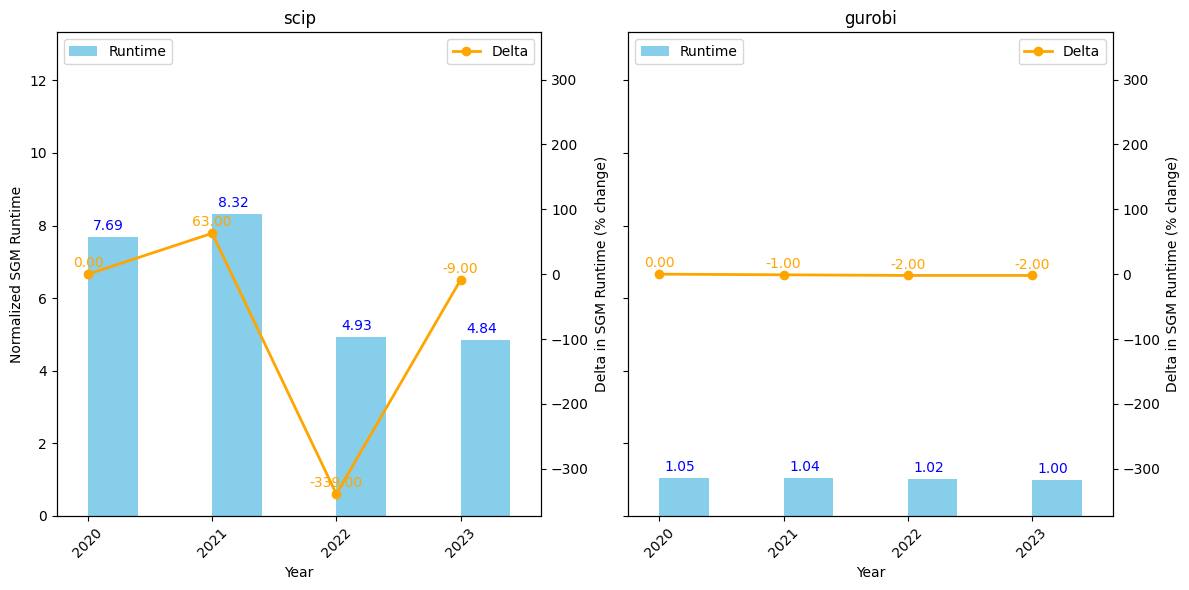

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame from the CSV data
data = {
    'solver': ['scip', 'gurobi'],
    '2020': [7.69, 1.05],
    '2021': [8.32, 1.04],
    '2022': [4.93, 1.02],
    '2023': [4.84, 1.0]
}

df = pd.DataFrame(data)

# Set the years as the index for easier plotting
years = df.columns[1:]
df.set_index('solver', inplace=True)

# Create a figure and axes for the bar charts
fig, axes = plt.subplots(1, len(df.index), figsize=(12, 6), sharey=True)

# Calculate deltas for all solvers
deltas_dict = {}
for solver in df.index:
    deltas_dict[solver] = df.loc[solver].diff().fillna(0)
    deltas_dict[solver] = deltas_dict[solver] * 100 # Make it percentage

# Determine limits for the secondary y-axis based on deltas
abs_max = max(abs(max(deltas.max() for deltas in deltas_dict.values())), abs(min(deltas.min() for deltas in deltas_dict.values())))
delta_max =  abs_max * 1.1
delta_min = - abs_max * 1.1

# Loop through each solver to create bar charts and line graphs
for ax, solver in zip(axes, df.index):
    # Bar chart for runtime
    df.loc[solver].plot(kind='bar', ax=ax, color='skyblue', position=0, width=0.4)
    for i, sgm in enumerate(df.loc[solver]):
        ax.annotate(f'{sgm:.2f}', (years[i], sgm), textcoords="offset points", xytext=(15, 5), ha='center', color='blue')

    # Overlay line graph for deltas
    ax2 = ax.twinx()
    ax2.plot(years, deltas_dict[solver], marker='o', color='orange', label='Delta', linewidth=2)

    # Set the limits for the secondary y-axis centered around 0
    ax2.set_ylim(delta_min, delta_max)

    # Annotate delta values above each point
    for i, delta in enumerate(deltas_dict[solver]):
        ax2.annotate(f'{delta:.2f}', (years[i], delta), textcoords="offset points", xytext=(0, 5), ha='center', color='orange')

    # Set titles and labels
    ax.set_title(solver)
    ax.set_xlabel('Year')
    ax.set_ylabel('Normalized SGM Runtime')
    ax.set_xticklabels(years, rotation=45)
    ax.legend(['Runtime'], loc='upper left')
    ax2.set_ylabel('Delta in SGM Runtime (% change)')
    ax2.legend(['Delta'], loc='upper right')

# Set the same limits for the primary y-axis across all subplots
y_min = 0  # Adjust as needed for better visibility
y_max = df.max().max() + 5
for ax in axes:
    ax.set_ylim(y_min, y_max)

# Adjust layout
plt.tight_layout()
plt.show()


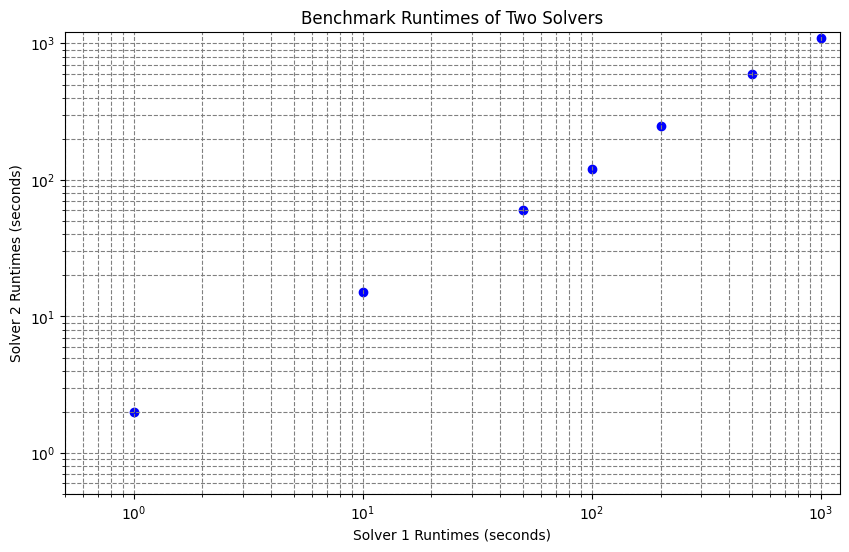

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: runtimes for two solvers (in seconds)
solver1_runtimes = np.array([1, 10, 50, 100, 200, 500, 1000])
solver2_runtimes = np.array([2, 15, 60, 120, 250, 600, 1100])

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(solver1_runtimes, solver2_runtimes, color='blue', marker='o')

# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Set axis limits
max_runtime = max(solver1_runtimes.max(), solver2_runtimes.max())
plt.xlim(0.5, max_runtime * 1.1)  # 10% more than the max runtime
plt.ylim(0.5, max_runtime * 1.1)  # 10% more than the max runtime

# Set axis ticks
ticks = [1, 10, 100, 1000]
plt.xticks(ticks)
plt.yticks(ticks)

# Add grid only at specified ticks
plt.grid(True, which='both', ls='--', color='gray')
plt.gca().set_xticks(ticks)  # Set x-ticks
plt.gca().set_yticks(ticks)  # Set y-ticks

# Add labels and title
plt.xlabel('Solver 1 Runtimes (seconds)')
plt.ylabel('Solver 2 Runtimes (seconds)')
plt.title('Benchmark Runtimes of Two Solvers')

# Show the plot
plt.show()


In [ ]:
import yaml
import pandas as pd

results = pd.read_csv(open('results/benchmark_results.csv'))
meta = yaml.safe_load(open('results/metadata.yaml'))

short_TO_benchs, long_TO_benchs = set(), set()
for n, b in meta['benchmarks'].items():
    for s in b['Sizes']:
        if s['Size'] == 'L':
            long_TO_benchs.add(n + '-' + s['Name'])
        elif s['Size'] in ['S', 'M']:
            short_TO_benchs.add(n + '-' + s['Name'])
        else:
            raise ValueError(f'Unknown size {s["Size"]}')

results['bench-size'] = results['Benchmark'] + '-' + results['Size']
results['solver-version'] = results['Solver'] + '-' + results['Solver Version']

long_results = results[results['bench-size'].isin(long_TO_benchs)]
len(long_results['bench-size'].unique()), long_results.shape

(15, (60, 19))

In [ ]:
print(long_results[['bench-size', 'Solver', 'Runtime (s)', 'Status']].to_csv(index=False))

bench-size,Solver,Runtime (s),Status
genx-elec_co2-15-168h,cbc,36000.0,TO
genx-elec_co2-15-168h,gurobi,8570.337038964004,ok
genx-elec_co2-15-168h,highs,36000.0,TO
genx-elec_co2-15-168h,scip,,ER
TIMES-GEO-global-netzero-31-20ts,cbc,36000.0,TO
TIMES-GEO-global-netzero-31-20ts,gurobi,3387.0468332590026,ok
TIMES-GEO-global-netzero-31-20ts,highs,55.55713430700416,warning
TIMES-GEO-global-netzero-31-20ts,scip,36000.0,TO
genx-elec_trex_co2-15-168h,cbc,36000.0,TO
genx-elec_trex_co2-15-168h,gurobi,15509.210943669,ok
genx-elec_trex_co2-15-168h,highs,36000.0,TO
genx-elec_trex_co2-15-168h,scip,,ER
genx-elec_trex_uc-15-24h,cbc,,ER
genx-elec_trex_uc-15-24h,gurobi,850.9396505309999,ok
genx-elec_trex_uc-15-24h,highs,36000.0,TO
genx-elec_trex_uc-15-24h,scip,,ER
temoa-US_9R_TS_SP-9-12,cbc,36000.0,TO
temoa-US_9R_TS_SP-9-12,gurobi,270.0389747189984,ok
temoa-US_9R_TS_SP-9-12,highs,21064.833701771,ok
temoa-US_9R_TS_SP-9-12,scip,36000.0,TO
times-etimeseu-europe-elec+heat-multi_stage-29-64ts,cbc,,ER
times-eti

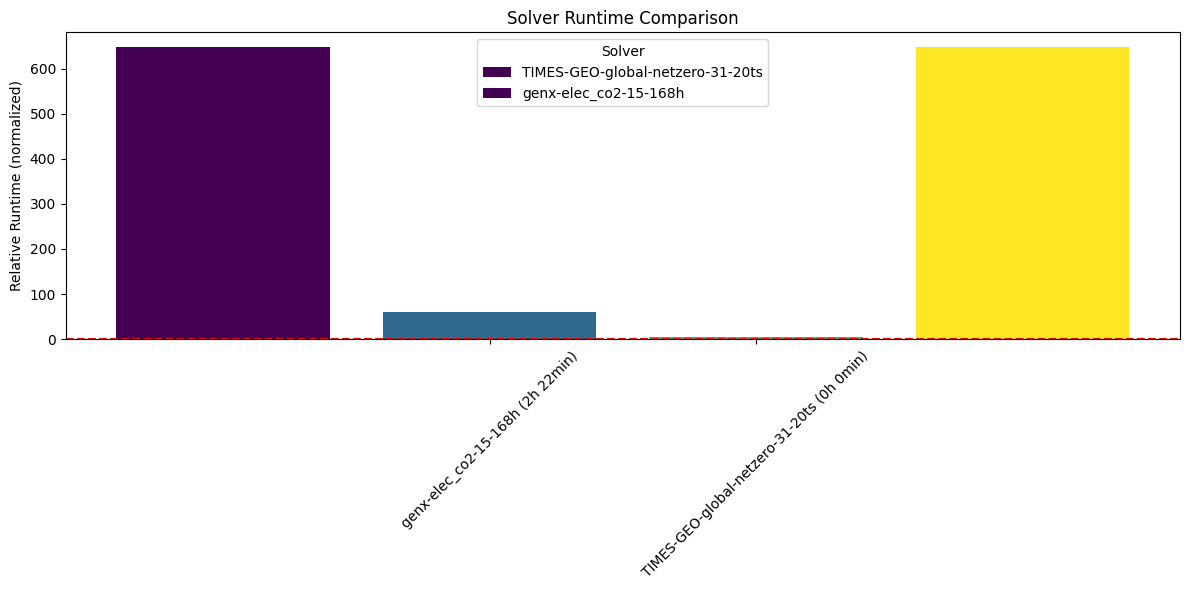

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample CSV data
data = """Benchmark,Solver,Runtime (s),Status
genx-elec_co2-15-168h,cbc,36000.0,TO
genx-elec_co2-15-168h,gurobi,8570.337038964004,ok
genx-elec_co2-15-168h,highs,36000.0,TO
genx-elec_co2-15-168h,scip,,ER
TIMES-GEO-global-netzero-31-20ts,cbc,36000.0,TO
TIMES-GEO-global-netzero-31-20ts,gurobi,3387.0468332590026,ok
TIMES-GEO-global-netzero-31-20ts,highs,55.55713430700416,warning
TIMES-GEO-global-netzero-31-20ts,scip,36000.0,TO
"""

# Read the data into a DataFrame
from io import StringIO
df = pd.read_csv(StringIO(data))

# Clean the data: convert runtimes to numeric and drop rows with NaN runtimes
df['Runtime (s)'] = pd.to_numeric(df['Runtime (s)'], errors='coerce')
df = df.dropna(subset=['Runtime (s)'])

# Find the fastest solver for each benchmark
fastest_runtimes = df.loc[df.groupby('Benchmark')['Runtime (s)'].idxmin()]

# Normalize runtimes
df = df.merge(fastest_runtimes[['Benchmark', 'Runtime (s)']], on='Benchmark', suffixes=('', '_fastest'))
df['Relative Runtime'] = df['Runtime (s)'] / df['Runtime (s)_fastest']

# Prepare data for plotting
solvers = df['Solver'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(solvers)))

# Sort benchmarks by fastest runtime
sorted_benchmarks = fastest_runtimes.sort_values('Runtime (s)').reset_index(drop=True)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))

for i, benchmark in enumerate(sorted_benchmarks['Benchmark']):
    benchmark_data = df[df['Benchmark'] == benchmark]
    ax.bar(benchmark_data['Solver'], benchmark_data['Relative Runtime'], color=colors, label=benchmark)

# Add a dotted line at y=1
ax.axhline(1, color='red', linestyle='--')

# Set x-ticks and labels
ax.set_xticks(sorted_benchmarks['Solver'])
ax.set_xticklabels([f"{benchmark} ({int(fastest_runtimes[fastest_runtimes['Benchmark'] == benchmark]['Runtime (s)'].values[0] // 3600)}h "
                    f"{int((fastest_runtimes[fastest_runtimes['Benchmark'] == benchmark]['Runtime (s)'].values[0] % 3600) // 60)}min)"
                    for benchmark in sorted_benchmarks['Benchmark']], rotation=45)

# Add labels and title
ax.set_ylabel('Relative Runtime (normalized)')
ax.set_title('Solver Runtime Comparison')
ax.legend(title='Solver')

# Add hover functionality
def hover(event):
    for bar in ax.patches:
        if bar.contains(event.x, event.y):
            ax.annotate(f'{bar.get_height():.2f}', (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        ha='center', va='bottom', fontsize=10, color='black')
            break

fig.canvas.mpl_connect('motion_notify_event', hover)

plt.tight_layout()
plt.show()
